# Introduction to Machine Learning via Nearest Neighbours


## Part 1 - Implement k-Nearest Neighbours (kNN) - 30 points

### Note:
This exercise closely follows the post by Scott Fortmann-Roe about bias-variance tradeoff (see references below). It is recommended that you think about each of the questions before referring to that essay.

In this exercise you will get familiar with a **non-parapmetric** learning algorithm called k-Nearest Neighbours (kNN), and will implement it. You will then analyse the bias-variance tradeoff and try to come up with the optimal kNN classifier for the given data.

For this exercise we will use hypothetical and artificial generated data.
### Nearest Neighbours
The kNN algorithm is simple - given a labeled sample set data, and a new sample, predict the label of this sample by using majority vote (or averaging) over the labels of the k-nearest neighbour of the new data in the sample set.

For this task, assume each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.

Implement a class called KNNClassifier and two methods:
- `fit`: should recieve the training data (an array of shape [n_samples, n_features]) and their labels (array of shape [n_samples]).
- `predict`: should recieve a set of data (an array of shape [n_samples, n_features]) and **return** their predicted labels (array of shape [n_samples]).

Use simple Euclidean distance to measure the distance between two points. In case two points in the training have the same distance from a given point to predict, the nearest would be the one appearing first in the training set.

Use majority vote between all kNN of a point to predict its label. In case the vote of all kNN is tied, you may predict whichever label you wish.

You may look up [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for reference.

* Bonus for nurdes: use kd-tree for efficiency, see [nearest neighbour search in wiki](https://en.wikipedia.org/wiki/Nearest_neighbor_search)

* Bonus for lazy nurdes: use [scipy's kd implementation](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.KDTree.html)

In [5]:
def euclideanDist(f1, f2):
    dist = 0.0
    for i in range(len(f1)):
        dist += abs(f1[i] - f2[i])**2
    return dist**(1/2)

class kNNClassifier:
  def __init__(self, n_neighbors):
    self.n_neighbors = n_neighbors
  def fit(self, X, y):
    # your code goes here
    self.data = X
    self.labels = y
  def predict(self, X):
    # your code goes here
    self.tdata = X
    self.tlabels = []
    for td in self.tdata:
      kNearest, distances, labels = [], [], []
      #Build lists containing first n_neighbors examples and their distances
      for i in range(self.n_neighbors):
          kNearest.append(self.data[i])
          distances.append(euclideanDist(td, self.data[i]))
          labels.append(self.labels[i])
      maxDist = max(distances) #Get maximum distance
      #Look at examples not yet considered
      for d, l in zip(self.data[self.n_neighbors:], self.labels[self.n_neighbors:]):
          dist = euclideanDist(td, d) 
          if dist < maxDist:
              #replace farther neighbor by this one
              maxIndex = distances.index(maxDist)
              kNearest[maxIndex] = d
              distances[maxIndex] = dist
              labels[maxIndex] = l
              maxDist = max(distances)   
      self.tlabels.append(max(labels, key=labels.count))   
    return self.tlabels



In [9]:
k1 = kNNClassifier(3)

In [7]:
k1.fit([[1,2],[2,1],[5,6], [7,8]],['r', 'r', 'b', 'b'])

In [8]:
k1.predict([[2,2], [6, 6]])

['r', 'b']

In [ ]:
t = ['r', 'r', 'b']
max(t, key=t.count)

In [ ]:
zip([[1,2],[2,1],[5,6], [7,8]],['r', 'r', 'b', 'b'])

In [ ]:
def findKNearest(example, exampleSet, k):
    kNearest, distances = [], []
    #Build lists containing first k examples and their distances
    for i in range(k):
        kNearest.append(exampleSet[i])
        distances.append(example.distance(exampleSet[i]))
    maxDist = max(distances) #Get maximum distance
    #Look at examples not yet considered
    for e in exampleSet[k:]:
        dist = example.distance(e)
        if dist < maxDist:
            #replace farther neighbor by this one
            maxIndex = distances.index(maxDist)
            kNearest[maxIndex] = e
            distances[maxIndex] = dist
            maxDist = max(distances)      
    return kNearest, distances

def KNearestClassify(training, testSet, label, k):
    """Assumes training & testSet lists of examples, k an int
       Predicts whether each example in testSet has label
       Returns number of true positives, false positives,
          true negatives, and false negatives"""
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for testCase in testSet:
        nearest, distances = findKNearest(testCase, training, k)
        #conduct vote
        numMatch = 0
        for i in range(len(nearest)):
            if nearest[i].getLabel() == label:
                numMatch += 1
        if numMatch > k//2: #guess label
            if testCase.getLabel() == label:
                truePos += 1
            else:
                falsePos += 1
        else: #guess not label
            if testCase.getLabel() != label:
                trueNeg += 1
            else:
                falseNeg += 1
    return truePos, falsePos, trueNeg, falseNeg

## Part 2 - Learn and evaluate kNN algorithm on artificial data

kNN is a **non-parametric** in the sense that no inner parameter of the model is learned by the sample training set (or maybe you could say that the number of parameters increases with the size of the sample set). However, the number of neighbours **k is considered a hyper-parameter**, and choosing the optimal value for it, is choosing the balance between bias and variance as discussed in class.




### An applied example: voter party registration

In this example, each voter is described by a vector of two features $(x_0, x_1)$, where $x_0$ describes how wealthy that voter is, and $x_1$ describes how religious the voter is. Label $y=1$ represents a Republican voter, and $y=-1$ represents a Democrat voter.

Use the given function `generate_data(m)` to create m samples with m labels. The labels are created using the following function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

and then a small fraction of the labels (chosen randomly, up to 10%) are flipped to represent unknown effect of features which are not measured. The sign of 0 is defined as 1 for this case.


Below is an example of generating 500 samples, and plotting them.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def true_boundary_voting_pred(wealth, religiousness):
  return religiousness-0.1*((wealth-5)**3-wealth**2+(wealth-6)**2+80)

def generate_data(m, seed=None):
  # if seed is not None, this function will always generate the same data
  np.random.seed(seed)

  X = np.random.uniform(low=0.0, high=10.0, size=(m,2))
  y = np.sign(true_boundary_voting_pred(X[:,0], X[:,1]))
  y[y==0] = 1
  samples_to_flip = np.random.randint(0,m//10)
  flip_ind = np.random.choice(m, samples_to_flip, replace=False)
  y[flip_ind] = -y[flip_ind]
  return X, y

def plot_labeled_data(X, y, no_titles=False):
  republicans = (y==1)
  democrats = (y==-1)
  plt.scatter(X[republicans,0], X[republicans,1], c='r')
  plt.scatter(X[democrats,0], X[democrats,1], c='b')
  if not no_titles:
    plt.xlabel('Wealth')
    plt.ylabel('Religiousness')
    plt.title('Red circles represent Republicans, Blues Democrats')

  plt.xlim([0, 10]);
  plt.ylim([0, 10]);
  plt.plot(np.linspace(0,10,1000), -true_boundary_voting_pred(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k');

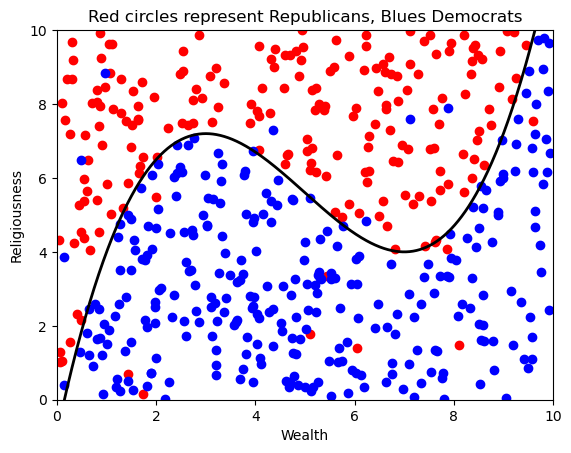

In [11]:
# Play this several times to see different sampling sets
X, y = generate_data(m=500)
plot_labeled_data(X, y)


### 1. Analyse the properties of kNN - 30 points
Generate multiple sample data sets of size 500 (use the given function above), and plot the decision plane for increasing values of k (e.g.: 1, 3, 5, 11, 21, 51, 99).

The decision plane should cover the range [0,10] for both axes, coloring the patches that would be classified as Republicans or Democrats in two colors. It should look something like this:

![decision plane](https://doc-14-14-docs.googleusercontent.com/docs/securesc/flg80o8vb463a3nd3i6da8hemig5me1b/hvii8ll4dscju8o17vuo2aab9aei8hgr/1543334400000/11934753179242311747/03422859225809857490/1chmyojft_R6ftfBhoPZuGN9AykyUS-cw?e=view&nonce=4i4j8lssjk6kc&user=03422859225809857490&hash=k9ogjg94ssot1vocu8uoeg4okkeekg6f)

https://drive.google.com/file/d/1chmyojft_R6ftfBhoPZuGN9AykyUS-cw/view?usp=sharing

Answer the following questions:
- How is the decision plain affected from changes in the sample set, as a function of k?
- Can you describe when do you underfit or overfit the data?
- How does the complexity of this model depends on k?

* Bonus for nurdes:
Use interactive slider for k to see the effect [see [interact](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)]

In [ ]:
# code goes here

Text goes here...

### 2. Finding the optimal k - 15 points
Sample a single sample set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets. Plot the train vs validation error for several k values, and choose the best k. Where do you underfit/overfit the data? Finally, estimate the generalization error of your chosen classifier using the test set. What would happen if you optimize directly on test? is the optimal k the same?


In [ ]:
# code goes here

Text goes here...

### 3. Using cross validation - 25 points
This time, put the test data aside (0.2 of the data), and apply 5-fold CV on the remaining data to evaluate the performance of each k value.
What is the size of the validation and train set now, in each CV iteration?
Did your final model selection change? Explain why.

In [ ]:
# code goes here

## References
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- http://scott.fortmann-roe.com/docs/MeasuringError.html
- http://scikit-learn.org/stable/modules/cross_validation.html